# Meta Modelling

이 모델은 다음과 같이 진행한다.
- 전용면적 60평을 기준으로 두데이터로 나누어서 각각 catboost 모델 학습
- 두 값을 합쳐서 다시 Ridge로 모델 학습 - 데이터 셋은 (y_train,y_train_pred)
- 결과 예측 -> ridgemodel.predict(y_test)

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 14.3 MB/s eta 0:00:00


# 패키지 선언

In [2]:
import matplotlib.pyplot as plt
# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [3]:
# Visualization
import matplotlib.font_manager as fm

# 나눔 폰트 경로 설정
font_path = '/Library/Fonts/NanumGothic.ttf'

# 나눔 폰트 설정
fe = fm.FontEntry(
    fname=font_path,  # ttf 파일이 저장되어 있는 경로
    name='NanumGothic'  # 이 폰트의 원하는 이름 설정
)
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'})  # 폰트 설정
plt.rc('font', family='NanumGothic')

# 데이터 불러오기

In [4]:
# path = '/content/drive/MyDrive/DL/ml_competition/ML_competition/data/'
path = '../data/'

In [27]:
# train_data = pd.read_csv(path + 'train_model.csv')
# test_data = pd.read_csv(path + 'test_model.csv')

train_data = pd.read_csv(path + 'train_model.csv')
test_data = pd.read_csv(path + 'test_model.csv')

# 데이터 가공

In [28]:
w = 1.28*3/10
def area_seperate(x):
    return int(x*w//10*10)

def st_seperate(x):
    if x < 60:
        return '0'
    else:
        return '1' 
    
train_data['평']=train_data['전용면적'].apply(area_seperate)
train_data['구분']=train_data['평'].apply(st_seperate)
train_data.drop('평',axis=1,inplace=True)

test_data['평']=test_data['전용면적'].apply(area_seperate)
test_data['구분']=test_data['평'].apply(st_seperate)
test_data.drop('평',axis=1,inplace=True)

####

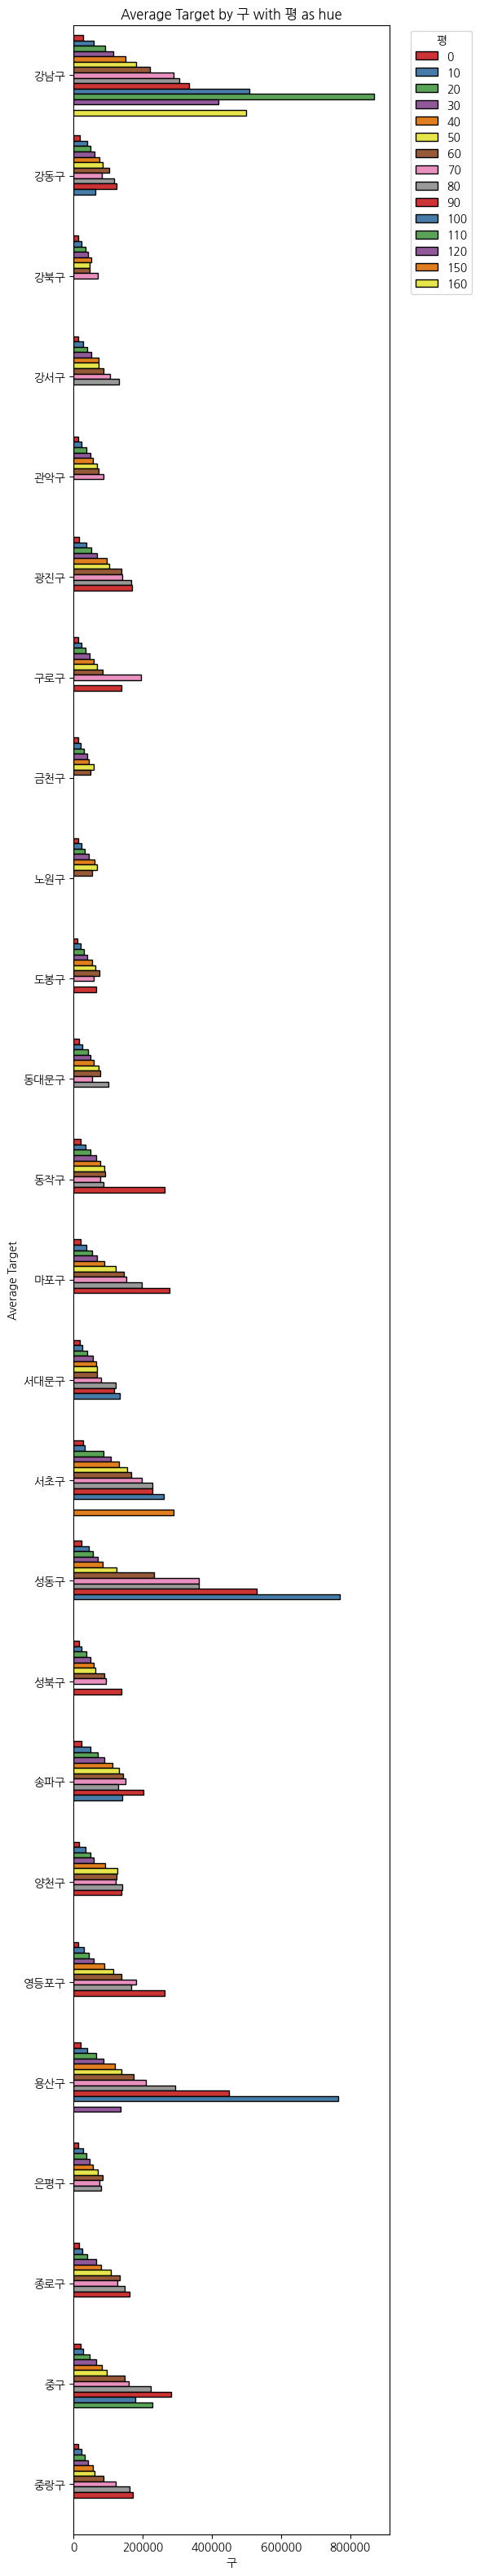

In [93]:
# 그룹화하여 평균 계산
grouped_data = train_data.groupby(['구', '평'])['target'].mean().reset_index()

# Seaborn 바 그래프 그리기
plt.figure(figsize=(5, 40))
barplot = sns.barplot(x='target', y='구', hue='평', data=grouped_data, palette='Set1', edgecolor='k')
plt.xlabel('구')
plt.ylabel('Average Target')
plt.title('Average Target by 구 with 평 as hue')
plt.legend(title='평', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 데이터 열 가공

In [29]:
import re
# 특수 문자 제거 또는 대체 함수
def clean_column_name(name):
   return re.sub(r'[^a-zA-Z0-9가-힣]', '_', name)

# 모든 열 이름을 정리
train_data.columns = [clean_column_name(col) for col in train_data.columns]
test_data.columns = [clean_column_name(col) for col in test_data.columns]

In [30]:
train_data.shape

(1118822, 41)

# 데이터 열 정리

In [31]:
# CSV 파일 불러오기
importance_df = pd.read_csv('feature_importances.csv')

# 중요도 순으로 정렬
feature_importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
sorted_features = feature_importance_df['feature'].tolist()

#display(best_feature_count)
best_feature_count = 17 # 적용할 파라미터의 수
best_features = sorted_features[:best_feature_count]
# display(best_features)
best_features.append('구분')

train = train_data[best_features]
test = test_data[best_features]

In [21]:
# 테스트를 위한 데이터셋 재가공
train_data_raw = train_data
mask = (train_data_raw['계약연도']==2023) & (train_data_raw['계약월']>3)
train_data = train_data_raw[~mask].reset_index(drop=True)
test_data = train_data_raw[mask].reset_index(drop=True)

train = train_data[best_features]
test = test_data[best_features]

In [22]:
test_data['target']

0        240000.0
1        249000.0
2        277000.0
3        245000.0
4        180000.0
           ...   
10627    104000.0
10628    106500.0
10629    100000.0
10630     67500.0
10631     69000.0
Name: target, Length: 10632, dtype: float64

#### LGBM을 위한 데이터 인코딩

In [7]:
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in train_data.columns:
    if pd.api.types.is_numeric_dtype(train_data[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k_전체동수', 'k_전체세대수', 'k_연면적', 'k_주거전용면적', 'k_전용면적별세대현황_60_이하_', 'k_전용면적별세대현황_60__85_이하_', 'k_85__135_이하', 'k_135_초과', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'distance_score', '계약연도', '계약월', '신축여부', '이자율', '시공능력평가_상위여부', '대장아파트_거리']
범주형 변수: ['아파트명', '도로명', 'k_단지분류_아파트_주상복합등등_', 'k_세대타입_분양형태_', 'k_관리방식', 'k_복도유형', 'k_난방방식', 'k_건설사_시공사_', 'k_시행사', '기타_의무_임대_임의_1_2_3_4', '구', '동', 'address', '거래유형', '급지']


In [8]:
# train과 test 데이터를 합쳐서 하나의 데이터프레임으로 만듭니다.
combined_data = pd.concat([train_data, test_data], axis=0)

#전용면적 로그 변환
combined_data['전용면적'] = np.log1p(combined_data['전용면적'])

# 각 범주형 변수에 대해 LabelEncoder를 적용합니다.
label_encoders = {}

for col in categorical_columns_v2:
    lbl = LabelEncoder()
    combined_data[col] = combined_data[col].astype(str)  # 데이터 타입을 문자열로 변환
    combined_data[col] = lbl.fit_transform(combined_data[col])
    label_encoders[col] = lbl  # 나중에 후처리를 위해 레이블인코더를 저장해둡니다.

# 인코딩된 데이터를 다시 train과 test 데이터로 나눕니다.
train_data_encoded = combined_data.iloc[:len(train_data)]
test_data_encoded = combined_data.iloc[len(train_data):]

In [144]:
train.columns

Index(['계약년월', '전용면적', '급지', '거래유형', '건축년도', '좌표Y', '좌표X', 'address', '구',
       '대장아파트_거리', '층', 'k_연면적', 'k_전체동수', '동', '주차대수', 'k_단지분류_아파트_주상복합등등_',
       'k_난방방식', '구분'],
      dtype='object')

In [15]:
%pip install wandb

# CAT

In [60]:
test.columns

Index(['계약년월', '전용면적', '급지', '거래유형', '건축년도', '좌표Y', '좌표X', 'address', '구',
       '대장아파트_거리', '층', 'k_연면적', 'k_전체동수', '동', '주차대수', 'k_단지분류_아파트_주상복합등등_',
       'k_난방방식', '구분'],
      dtype='object')

### Nonlog

In [33]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import Ridge
import wandb
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold

# 나누는 기준이 되는 열 이름
st_col = '구분'

categorical_features = train.select_dtypes(include=['object']).columns.tolist()
# 범주형 변수를 저장한 리스트에서 위의 st_col은 뺌.
if st_col in categorical_features:
    categorical_features.remove(st_col)

# 범주형 변수들을 일괄적으로 str로 변경.
for col in categorical_features:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)

# 최종 예측 결과를 저장할 데이터프레임
models = {}
train_predictions = pd.DataFrame({'target':np.zeros(len(train))})
val_predictions = pd.DataFrame({'target':np.zeros(len(train))})
final_predictions = pd.DataFrame({'target':np.zeros(len(test))})

# cat 모델 실행
districts = train[st_col].unique()
for district in districts:
    print(f"Processing district: {district}")

    X = train[train[st_col] == district].drop(st_col,axis=1)
    y = train_data.loc[X.index,'target']

    X_test = test[test[st_col] == district].drop(st_col,axis=1)

    # WandB 초기화
    run_name = f"lightGBM_{district}_{datetime.now().strftime('%m%d_%H%M')}"
    wandb.init(
        project="re_price_prediction",
        group="lightGBM final",
        name=run_name,
        reinit=True,
        config={
        'iterations': 100000,#trial.suggest_int('iterations', 1500, 3000),
        'learning_rate':0.014301,
        'depth':10,
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_seed': 42,
        'early_stopping_rounds': 50,
        'bootstrap_type':'Bernoulli',
        'task_type': 'GPU',  # GPU 사용 설정
        'devices': '0:1:2:3:4:5:6:7:8:9:10:11:12:13:14:15'    # 여러 GPU 사용 설정 (예: 0번과 1번 GPU 사용)
    }
    )

    # LightGBM 모델 정의
    params = dict(wandb.config)
    model = CatBoostRegressor(**params)

    # wandb에 로깅하는 콜백 함수
    def log_to_wandb(env):
        for data_name, eval_name, eval_result, _ in env.evaluation_result_list:
            metric_name = f"{data_name}_{eval_name}"
            wandb.log({metric_name: eval_result})

    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42)

    # 데이터가 적은 셋에 kfold를 적용해본다.        
    if district=='1':
        kf = KFold(n_splits=3,shuffle=True,random_state=42)
        for train_idx, valid_idx in kf.split(X):

            X_train_kf = X.iloc[train_idx].reset_index(drop = True)
            y_train_kf = y.iloc[train_idx].reset_index(drop = True)

            X_val_kf = X.iloc[valid_idx].reset_index(drop = True)
            y_val_kf = y.iloc[valid_idx].reset_index(drop = True)
            
            # CatBoost Pool 생성
            train_pool = Pool(X_train_kf, y_train_kf, cat_features=categorical_features)
            val_pool = Pool(X_val_kf, y_val_kf, cat_features=categorical_features)
            model.fit(train_pool, eval_set=val_pool, verbose=100)
    else:
        # CatBoost Pool 생성
        train_pool = Pool(X_train, y_train, cat_features=categorical_features)
        val_pool = Pool(X_val, y_val, cat_features=categorical_features)
        model.fit(train_pool, eval_set=val_pool, verbose=100)
    
    models[district] = model

    train_predictions.loc[X_train.index, 'target'] = model.predict(X_train)
    val_predictions.loc[X_val.index, 'target'] = model.predict(X_val)
    final_predictions.loc[X_test.index, 'target'] = model.predict(X_test)

    print(f"Best iteration: {model.best_iteration_}")
    print(f"Best score: {model.best_score_['validation']['RMSE']}")

    # wandb에 최종 점수 로깅
    wandb.log({"final_best_score": model.best_score_['validation']['RMSE']})

    # wandb 실행 종료
    wandb.finish()

train_predictions = train_predictions[train_predictions['target']!=0]
val_predictions = val_predictions[val_predictions['target']!=0]

# 빈 값을 0으로 채우기 (혹은 적절한 방법으로 처리)
if len(final_predictions[final_predictions['target']==0])==0:

    # 메타 모델 학습
    meta_model = Ridge(alpha=1.0)
    meta_model.fit(train_predictions, train_data.loc[train_predictions.index,'target'])

    # 메타 모델 예측
    y_train_pred = meta_model.predict(train_predictions)
    y_val_pred = meta_model.predict(val_predictions)
    y_test_pred = meta_model.predict(final_predictions)

    y_best = pd.read_csv(path + 'output_cho.csv',index_col=0)

    # 성능 평가
    train_rmse = np.sqrt(mean_squared_error(train_data.loc[train_predictions.index,'target'], y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(train_data.loc[val_predictions.index,'target'], y_val_pred))
    # test_rmse = np.sqrt(mean_squared_error(test_data['target'], y_test_pred))

    test_rmse = np.sqrt(mean_squared_error(y_best, y_test_pred))


    print(f'Train RMSE: {train_rmse}')
    print(f'val RMSE: {val_rmse}')
    print(f'Test RMSE: {test_rmse}')

    pd.DataFrame({'target':y_test_pred}).to_csv(path + 'output_grade.csv', index=False)
    # final_predictions.to_csv(path + 'output_grade.csv', index=False)

    # 최종 예측 결과를 CSV 파일로 저장
    if not final_predictions.empty:
        print("Predictions saved to output.csv")
    else:
        print("No predictions were made. Check your data.")
else:
    print('뭔가 잘못됐어요. test에 0값이 존재합니다.')
    print({len(final_predictions[final_predictions['target']==0])})
    print(len(train_predictions)+len(val_predictions))
    print(len(train))



Processing district: 0


0:	learn: 39605.2988084	test: 39637.5138801	best: 39637.5138801 (0)	total: 49.3ms	remaining: 1h 22m 14s
100:	learn: 15692.1724983	test: 15537.5093532	best: 15537.5093532 (100)	total: 4.53s	remaining: 1h 14m 37s
200:	learn: 10521.7568355	test: 10418.9496563	best: 10418.9496563 (200)	total: 9.03s	remaining: 1h 14m 41s
300:	learn: 9035.1358734	test: 8980.2396661	best: 8980.2396661 (300)	total: 13.6s	remaining: 1h 15m 16s
400:	learn: 8349.3242433	test: 8315.8063480	best: 8315.8063480 (400)	total: 18.2s	remaining: 1h 15m 24s
500:	learn: 7899.0161351	test: 7878.0678007	best: 7878.0678007 (500)	total: 22.8s	remaining: 1h 15m 24s
600:	learn: 7540.3315208	test: 7528.3513257	best: 7528.3513257 (600)	total: 27.4s	remaining: 1h 15m 27s
700:	learn: 7243.6786527	test: 7239.2284494	best: 7239.2284494 (700)	total: 31.9s	remaining: 1h 15m 23s
800:	learn: 7005.8354833	test: 7009.3630783	best: 7009.3630783 (800)	total: 36.5s	remaining: 1h 15m 26s
900:	learn: 6797.0661692	test: 6807.0204483	best: 6807.020

final_best_score,▁
final_best_score,4201.61048


Processing district: 1


0:	learn: 110386.9707082	test: 114915.6001745	best: 114915.6001745 (0)	total: 100ms	remaining: 2h 47m 20s
100:	learn: 50907.2043134	test: 53755.1139639	best: 53755.1139639 (100)	total: 8.64s	remaining: 2h 22m 23s
200:	learn: 37240.6701725	test: 40292.2692568	best: 40292.2692568 (200)	total: 17.1s	remaining: 2h 21m 20s
300:	learn: 33194.1782111	test: 36270.6647105	best: 36270.6647105 (300)	total: 25s	remaining: 2h 17m 47s
400:	learn: 31564.7041951	test: 34622.7653372	best: 34622.7653372 (400)	total: 32s	remaining: 2h 12m 36s
500:	learn: 30557.9959174	test: 33622.5068710	best: 33622.2033647 (499)	total: 38.7s	remaining: 2h 7m 58s
600:	learn: 29575.3037135	test: 32665.0829698	best: 32665.0502005 (599)	total: 45s	remaining: 2h 3m 57s
700:	learn: 28859.3454617	test: 32013.0693246	best: 32013.0693246 (700)	total: 50.5s	remaining: 1h 59m 14s
800:	learn: 28258.0386018	test: 31473.0589363	best: 31473.0589363 (800)	total: 56.4s	remaining: 1h 56m 24s
900:	learn: 27737.9368302	test: 31047.5392606	

final_best_score,▁
final_best_score,25274.49661


Train RMSE: 4569.682006405557
val RMSE: 5087.71916072561
Test RMSE: 10616.211480767168
Predictions saved to output.csv
